In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
acled = pd.read_csv("Asia-Pacific_2018-2024_Nov22.csv")
# print(acled.head())

In [3]:
myanmar_raw = acled[acled.country == "Myanmar"]
print(f"Raw file has {len(myanmar_raw)} observations from Myanmar")

Raw file has 82842 observations from Myanmar


In [4]:
myanmar21 = myanmar_raw[myanmar_raw.year >= 2021].copy()
# print(len(myanmar21), " observations from 2021 onward")
print("Columns: ", myanmar21.columns)

Columns:  Index(['event_id_cnty', 'event_date', 'year', 'time_precision',
       'disorder_type', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'civilian_targeting', 'iso', 'region', 'country',
       'admin1', 'admin2', 'admin3', 'location', 'latitude', 'longitude',
       'geo_precision', 'source', 'source_scale', 'notes', 'fatalities',
       'tags', 'timestamp'],
      dtype='object')


In [17]:
# Remove 'non-violent' action
event_drop = ['Protests', 'Strategic developments', 'Riots']
myanmar21 = myanmar21[~myanmar21.event_type.isin(event_drop)].copy()
# myanmar21 = myanmar21[myanmar21.event_type == 'Battles'].copy()

In [18]:
myanmar21 = myanmar21.copy()
myanmar21['event_date'] = pd.to_datetime(myanmar21['event_date'])
myanmar21['month'] = myanmar21['event_date'].dt.to_period('M')

# Group by month and event type, and count the number of events
monthly_event_counts = myanmar21.groupby(['month', 'event_type']).size().unstack(fill_value=0)

<Figure size 1200x800 with 0 Axes>

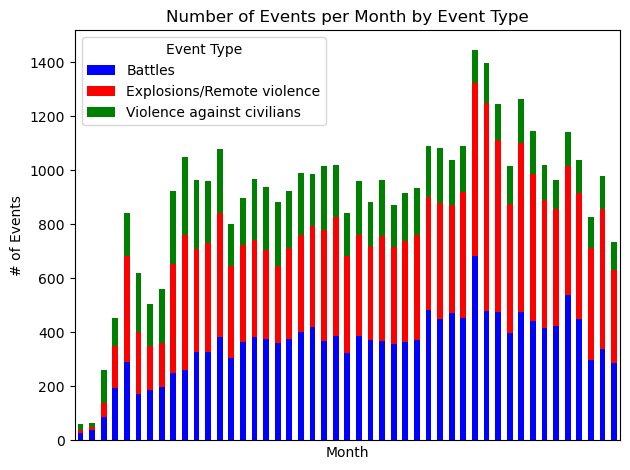

In [22]:
# Plot the stacked bar chart
plt.figure(figsize=(12, 8))
monthly_event_counts.plot(kind='bar', stacked=True, color=['blue', 'red', 'green'])
plt.xlabel('Month')
plt.ylabel('# of Events')
plt.title('Number of Events per Month by Event Type')
plt.xticks([])
plt.legend(title='Event Type')
plt.tight_layout()
plt.show()

In [ ]:
actor1_keep = ["Military Forces of Myanmar (2021-)", "KNU/KNLA: Karen National Union/Karen National Liberation Army"]

actor2_keep  = ["Police Forces of Myanmar (2021-)", "ULA/AA: United League of Arakan/Arakan Army", "KIO/KIA: Kachin Independence Organization/Kachin Independence Army", ""]